<a href="https://colab.research.google.com/github/daayvm/DiplomadoCD/blob/main/Proyecto_M2_DVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto M2. Modelación Supervisada

Medical Cost Personal Datasets

Link: https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

Bibliotecas

In [10]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 11.1 MB/s eta 0:00:00


In [11]:
# Bibliotecas
import os
import pandas as pd
import numpy as np

# KS test, ji-cuadrada
from scipy.stats import ks_2samp, chi2_contingency, randint, uniform
import scipy.stats as stats

# Graficas
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import andrews_curves
from matplotlib.colors import ListedColormap
from plotnine import ggplot, aes, geom_boxplot, geom_density, facet_wrap, theme_bw, labs, ggtitle

# Valores atipicos
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.mcd import MCD


# Valores ausentes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Modelos
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

Carga de datos

In [12]:
df = pd.read_csv("/content/insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [19]:
print("Dimensión", df.shape)

Dimensión (1338, 7)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Valores ausentes

In [21]:
def is_na_df(df):
    #Establecemos el resumen de NAs por columna
    na_summary = (
        df.isna().sum()
        .reset_index()
        .rename(columns={"index": "columna", 0: "n_missing"})
    )

    #Tomamos totales y prporciones
    na_summary["total"] = len(df)
    na_summary["prop_missing"] = na_summary["n_missing"] / na_summary["total"]
    na_summary["prop_original"] = 1 - na_summary["prop_missing"]

    #Filtramos solo columnas con al menos 1 NA
    na_summary = na_summary[na_summary["n_missing"] > 0].reset_index(drop=True)

    #Agregamos fila resumen global
    total_missing = df.isna().sum().sum()
    total_elements = df.size
    prop_missing_global = total_missing / total_elements
    prop_original_global = 1 - prop_missing_global

    resumen = pd.DataFrame({
        "columna": ["TOTAL"],
        "n_missing": [total_missing],
        "total": [total_elements],
        "prop_missing": [prop_missing_global],
        "prop_original": [prop_original_global]
    })

    na_summary = pd.concat([na_summary, resumen], ignore_index=True)

    return na_summary

In [22]:
is_na_df(df)

,columna,n_missing,total,prop_missing,prop_original
0,TOTAL,0,9366,0.0,1.0


*No existen valores ausentes dentro del data set*

Balance de la variable obejtivo

In [23]:
conteo = df['charges'].value_counts()
display(pd.concat([df['charges'].value_counts(), df['charges'].value_counts(normalize=True).apply(lambda x: '{:.2%}'.format(x))], axis=1))

balance_ratio = conteo.min() / conteo.max()

print(f"\nÍndice de balance de {balance_ratio:.2%}", end=" por lo que ")

if balance_ratio > 0.7:
    print("la variable está relativamente balanceada.")
elif balance_ratio > 0.3:
    print("hay cierto desbalance, podría afectar algunos modelos.")
else:
    print("hay fuerte desbalance.")

,count,proportion
charges,,
1639.56310,2,0.15%
2221.56445,1,0.07%
19798.05455,1,0.07%
13063.88300,1,0.07%
13555.00490,1,0.07%
...,...,...
1149.39590,1,0.07%
37079.37200,1,0.07%
4738.26820,1,0.07%



Índice de balance de 50.00% por lo que hay cierto desbalance, podría afectar algunos modelos.


Analisis Exploratorio

In [24]:
#Definimos un objeto para graficar
class analyze:
    # Inicializamos la clase
    def __init__(self, df, num_vars, cat_vars):
        self.df = df
        self.num_vars = num_vars
        self.cat_vars = cat_vars

    #Método para graficar variables numéricas
    def plot_num(self):
        for var in self.num_vars:
            fig = make_subplots(rows=1, cols=2, subplot_titles=(f"{var} - Boxplot", f"{var} - Histograma"))

            # Boxplot
            fig.add_trace(
                go.Box(y=self.df[var], name="Boxplot", marker_color="#008080"),
                row=1, col=1
            )

            # Histograma
            fig.add_trace(
                go.Histogram(x=self.df[var], name="Histograma",
                             marker_color="#00a77d", nbinsx=50,
                             histnorm='probability density'),
                row=1, col=2
            )

            fig.update_layout(title_text=f"Variable: {var}", height=400, width=800)
            fig.show()

    #Método para graficar variables categóricas
    def plot_cat(self):
        for var in self.cat_vars:
            value_counts = self.df[var].value_counts()
            labels = value_counts.index.astype(str)
            values = value_counts.values

            fig = go.Figure(
                data=[go.Pie(labels=labels, values=values, textinfo='percent+label')]
            )

            fig.update_layout(title_text=f"Variable: {var}", height=400, width=500)
            fig.show()

    #Método para graficar la matriz de correlación de numéricas
    def corr_matrix(self):
        corr_matrix = self.df[self.num_vars].corr()

        fig = go.Figure(data=go.Heatmap(
            z=corr_matrix.values,
            x=corr_matrix.columns,
            y=corr_matrix.columns,
            colorscale='Viridis'))

        fig.update_layout(
            title='Matriz de Correlación',
            width=800,
            height=600
        )

        fig.show()

In [25]:
#Definimos las variables categoricas
var_cat = ['sex','smoker','region','charges']
var_cat

['sex', 'smoker', 'region', 'charges']

In [26]:
# Definimos las variables numericas
var_num = list(set(df.columns) - set(var_cat))
var_num

['children', 'bmi', 'age']

In [27]:
analisis = analyze(df, var_num, var_cat)

In [28]:
analisis.plot_num()

In [29]:
perc=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]

In [30]:
# Vemos las estadísticas
df[var_num].describe(percentiles=perc).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
children,1338.0,1.094918,1.205493,0.00,0.00000,0.000,0.00000,1.0,2.00000,3.000,5.0000,5.00
bmi,1338.0,30.663397,6.098187,15.96,17.89515,21.256,26.29625,30.4,34.69375,41.106,46.4079,53.13
age,1338.0,39.207025,14.049960,18.00,18.00000,18.000,27.00000,39.0,51.00000,62.000,64.0000,64.00


In [31]:
analisis.plot_cat()

Valores Atipicos

Con curvas De Adrew

In [60]:
from pandas.plotting import andrews_curves
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def andrews_curve_scaled(df_num):
    """
    df_num: DataFrame solo con variables numéricas
    """
    # 1. Escalar variables numéricas
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_num)
    df_scaled = pd.DataFrame(data_scaled, columns=df_num.columns)

    # 2. Columna dummy para poder usar class_column
    df_scaled["grupo"] = "datos"

    # 3. Graficar Curvas de Andrews
    plt.figure(figsize=(12,5))
    andrews_curves(df_scaled, class_column="grupo", alpha=0.2, colormap=None)
    plt.title("Curvas de Andrews")
    plt.ylabel("Valor transformado")

    # Quitar la leyenda (no aporta nada aquí)
    leg = plt.legend()
    if leg is not None:
        leg.remove()

    plt.show()



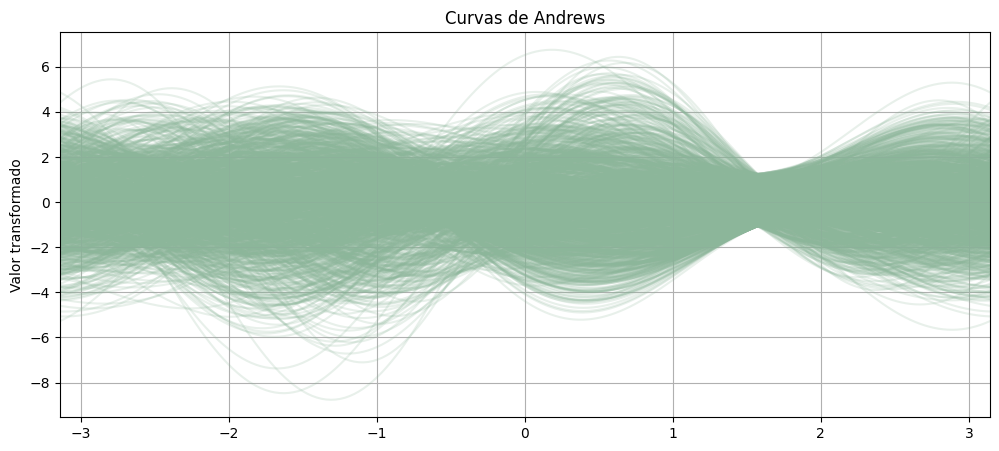

In [61]:
var_num = ["age", "bmi", "children", "charges"]  # o las que estés usando
andrews_curve_scaled(df[var_num])


Con insolation forest

In [32]:
#Aplicamos Isolation forest para valores atípicos.
def detect_outliers_iforest(df, n_estimators=100, contamination=0.05, random_state=1989):
    model = IForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    model.fit(df)
    preds = model.predict(df)
    return df[preds == 1]

In [33]:
df_outliers = detect_outliers_iforest(df[var_num])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but IsolationForest was fitted without feature names



In [34]:
df_outliers

,children,bmi,age
32,5,28.60,19
61,4,33.66,25
71,5,28.50,31
83,4,41.23,48
116,0,49.06,58
...,...,...,...
1245,5,24.30,28
1272,5,25.52,43
1317,0,53.13,18
1318,4,39.71,35


In [35]:
df_outliers.shape

(67, 3)

In [36]:
percentage_outliers = (len(df_outliers) / len(df)) * 100

print(f"El porcentaje de valores atípicos es: {percentage_outliers:.2f}%")

El porcentaje de valores atípicos es: 5.01%


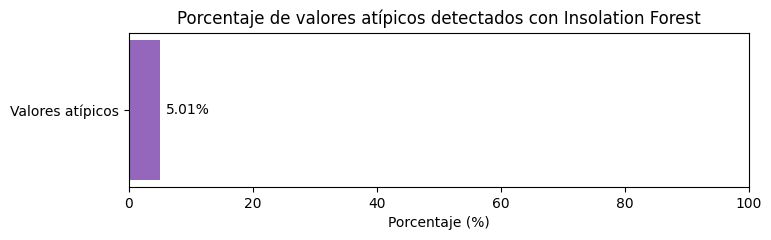

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,2))
plt.barh(["Valores atípicos"], [percentage_outliers], color="#9467bd")
plt.xlim(0, 100)
plt.xlabel("Porcentaje (%)")
plt.title("Porcentaje de valores atípicos detectados con Insolation Forest")

# Mostrar valor exacto
plt.text(percentage_outliers + 1, 0, f"{percentage_outliers:.2f}%", va='center')

plt.show()


Matriz de Correlación

<Axes: >

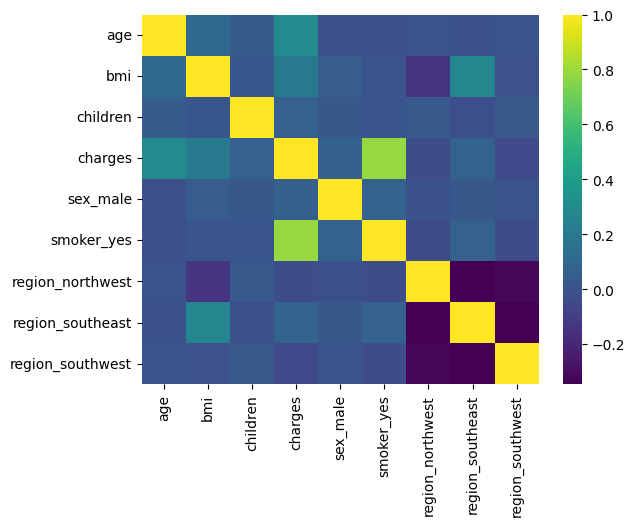

In [37]:
import pandas as pd
df_encoded = pd.get_dummies(df, drop_first=True)
corr = df_encoded.corr()
sns.heatmap(corr, cmap='viridis')

Entrenamiento

In [40]:
# Definimos X (variables explicativas) e y (variable objetivo)
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

# División en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((936, 8), (402, 8), (936,), (402,))

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Modelo 1: Regresión Lineal
model_lr = LinearRegression()

# Modelo 2: Árbol de Decisión
model_tree = DecisionTreeRegressor(
    max_depth=5,
    random_state=42
)

# Modelo 3: Random Forest
model_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42
)


In [42]:
# Entrenamos cada modelo con los datos de entrenamiento
model_lr.fit(X_train, y_train)
model_tree.fit(X_train, y_train)
model_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=6, n_estimators=200, random_state=42)

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Función para calcular métricas
def calcular_metricas(nombre, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        "Modelo": nombre,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

# Predicciones en el conjunto de prueba
y_pred_lr = model_lr.predict(X_test)
y_pred_tree = model_tree.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

# Calculamos métricas para cada modelo
resultados = []

resultados.append(calcular_metricas("Regresión Lineal", y_test, y_pred_lr))
resultados.append(calcular_metricas("Árbol de Decisión", y_test, y_pred_tree))
resultados.append(calcular_metricas("Random Forest", y_test, y_pred_rf))

# Convertimos a DataFrame para verlo bonito
resultados_df = pd.DataFrame(resultados)
resultados_df


,Modelo,MAE,MSE,RMSE,R2
0,Regresión Lineal,4145.450556,3.378051e+07,5812.100272,0.769612
1,Árbol de Decisión,2716.131877,2.111384e+07,4594.980191,0.856000
2,Random Forest,2504.770881,1.922525e+07,4384.660499,0.868881


/tmp/ipython-input-2925436037.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




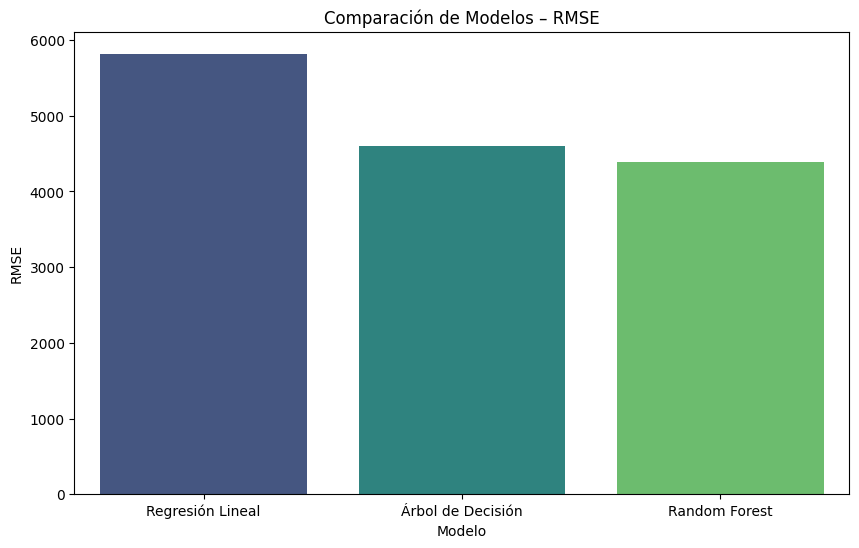

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=resultados_df, x="Modelo", y="RMSE", palette="viridis")

plt.title("Comparación de Modelos – RMSE")
plt.ylabel("RMSE")
plt.xlabel("Modelo")
plt.xticks(rotation=0)
plt.show()


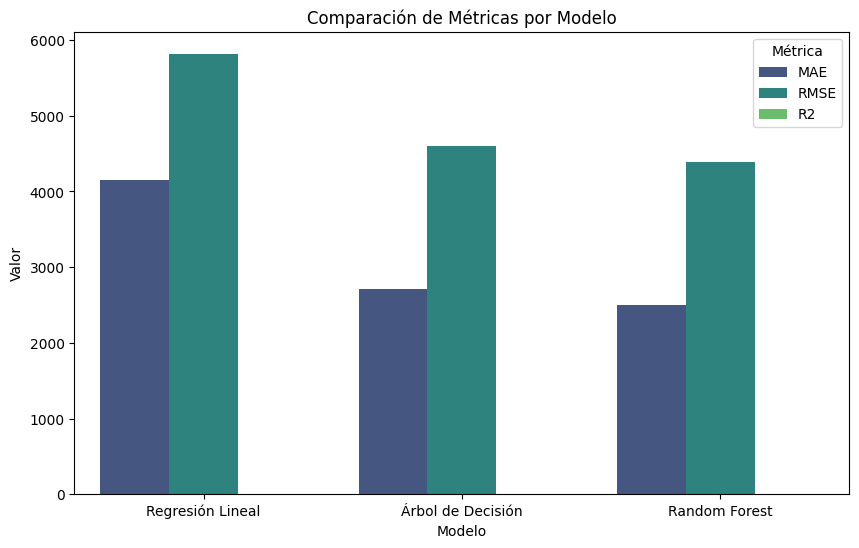

In [47]:
resultados_melt = resultados_df.melt(id_vars="Modelo",
                                     value_vars=["MAE", "RMSE", "R2"],
                                     var_name="Métrica",
                                     value_name="Valor")

plt.figure(figsize=(10,6))
sns.barplot(data=resultados_melt, x="Modelo", y="Valor", hue="Métrica", palette="viridis")

plt.title("Comparación de Métricas por Modelo")
plt.xlabel("Modelo")
plt.ylabel("Valor")
plt.legend(title="Métrica")
plt.show()


/tmp/ipython-input-92460839.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




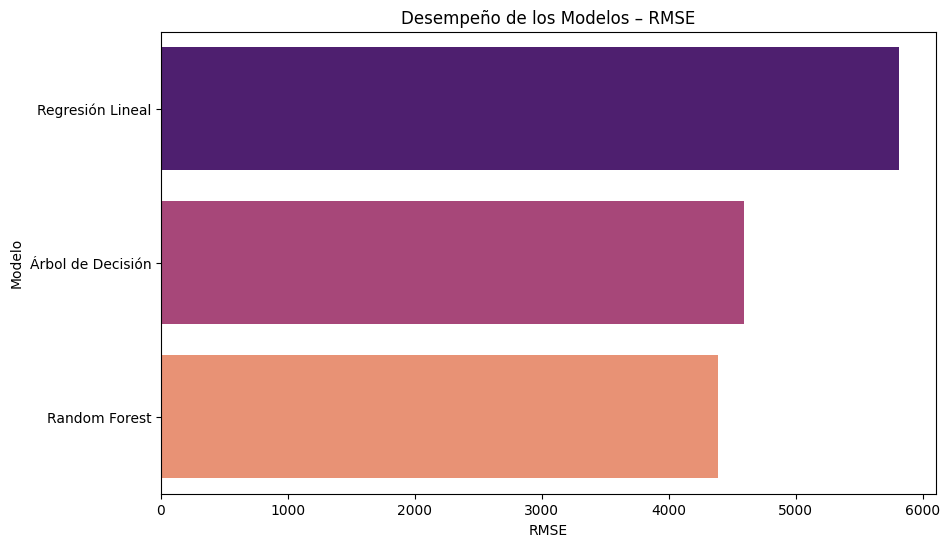

In [48]:
plt.figure(figsize=(10,6))
sns.barplot(data=resultados_df, y="Modelo", x="RMSE", palette="magma")

plt.title("Desempeño de los Modelos – RMSE")
plt.xlabel("RMSE")
plt.ylabel("Modelo")
plt.show()


GRAFICAS INDIVIDUALES

/tmp/ipython-input-69900918.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




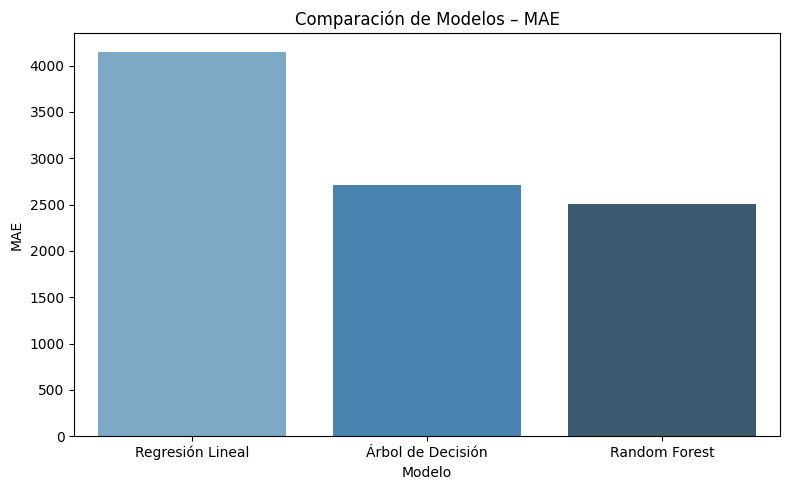

In [49]:
plt.figure(figsize=(8,5))
sns.barplot(data=resultados_df, x="Modelo", y="MAE", palette="Blues_d")
plt.title("Comparación de Modelos – MAE")
plt.ylabel("MAE")
plt.xlabel("Modelo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2051921950.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




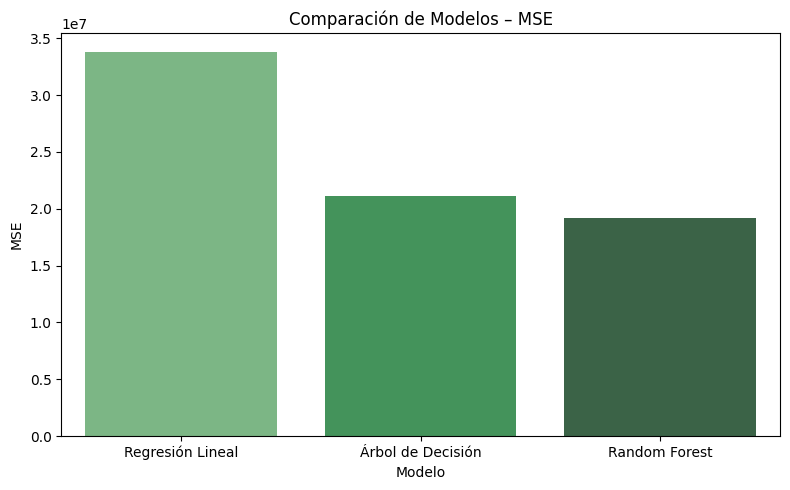

In [50]:
plt.figure(figsize=(8,5))
sns.barplot(data=resultados_df, x="Modelo", y="MSE", palette="Greens_d")
plt.title("Comparación de Modelos – MSE")
plt.ylabel("MSE")
plt.xlabel("Modelo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipython-input-370744003.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




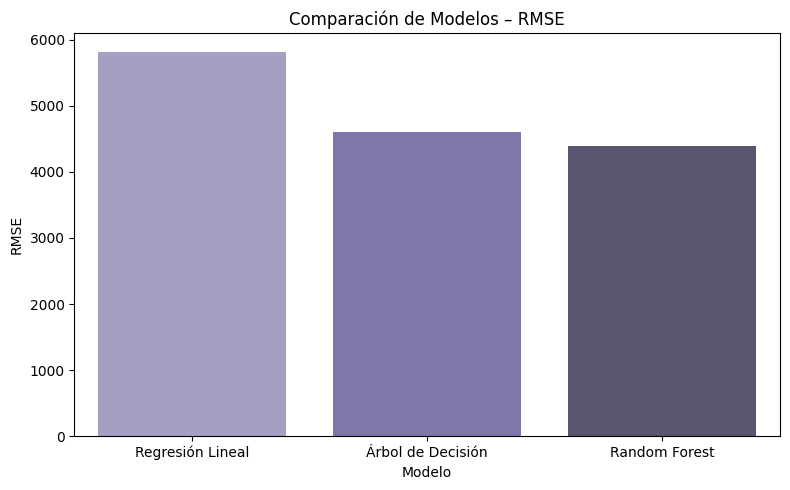

In [51]:
plt.figure(figsize=(8,5))
sns.barplot(data=resultados_df, x="Modelo", y="RMSE", palette="Purples_d")
plt.title("Comparación de Modelos – RMSE")
plt.ylabel("RMSE")
plt.xlabel("Modelo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipython-input-590813350.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




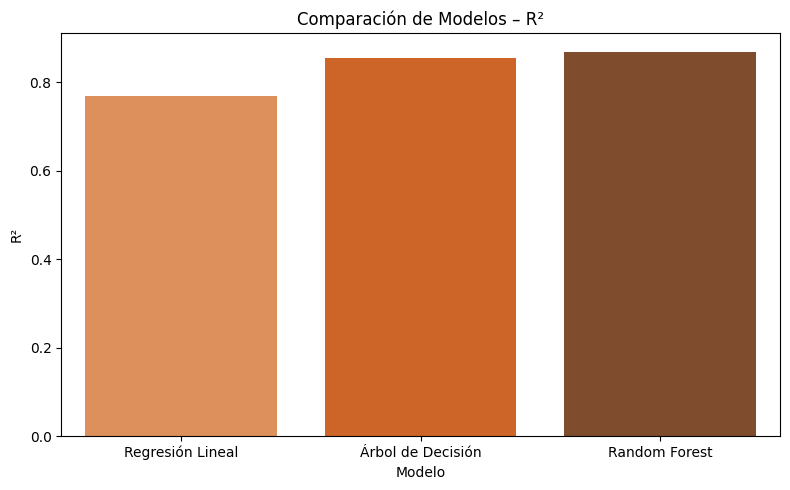

In [52]:
plt.figure(figsize=(8,5))
sns.barplot(data=resultados_df, x="Modelo", y="R2", palette="Oranges_d")
plt.title("Comparación de Modelos – R²")
plt.ylabel("R²")
plt.xlabel("Modelo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
